In [3]:
import sframe                            # see below for install instruction

In [1]:
import matplotlib.pyplot as plt          # plotting
import numpy as np                       # dense matrices
%matplotlib inline

In [2]:
from scipy.sparse import csr_matrix      # sparse matrices

In [48]:
from sklearn.metrics.pairwise import euclidean_distances

## Load in the dataset

We will be using the same dataset of Wikipedia pages that we used in the Machine Learning Foundations course (Course 1). Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).

In [5]:
wiki = sframe.SFrame('people_wiki.gl/')
wiki = wiki.add_row_number()             # add row number, starting at 0

In [9]:
wiki.head()

id,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...
1,<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...
2,<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...
3,<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...
4,<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...
5,<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...
6,<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...
7,<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...
8,<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...
9,<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...


## Extract word count vectors

For your convenience, we extracted the word count vectors from the dataset. The vectors are packaged in a sparse matrix, where the i-th row gives the word count vectors for the i-th document. Each column corresponds to a unique word appearing in the dataset. The mapping between words and integer indices are given in people_wiki_map_index_to_word.gl.

To load in the word count vectors, define the function

In [6]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [11]:
word_count = load_sparse_csr('people_wiki_word_count.npz')

In [15]:
word_count[0,:]

<1x547979 sparse matrix of type '<type 'numpy.int64'>'
	with 139 stored elements in Compressed Sparse Row format>

In [17]:
# The word-to-index mapping is given by

In [8]:
map_index_to_word = sframe.SFrame('people_wiki_map_index_to_word.gl/')

In [16]:
map_index_to_word.head()

feature,category,index
feature,bioarchaeologist,0
feature,leaguehockey,1
feature,electionruss,2
feature,teramoto,3
feature,trumpeterpercussionist,4
feature,spoofax,5
feature,mendelssohni,6
feature,crosswise,7
feature,yec,8
feature,asianthemed,9


## Find nearest neighbors using word count vectors

Let's start by finding the nearest neighbors of the Barack Obama page using the word count vectors to represent the articles and Euclidean distance to measure distance. For this, we will use scikit-learn's implementation of k-nearest neighbors. We first create an instance of the NearestNeighbor class, specifying the model parameters. Then we call the fit() method to attach the training set.

In [18]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(metric='euclidean', algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [19]:
print wiki[wiki['name'] == 'Barack Obama']

+-------+-------------------------------+--------------+
|   id  |              URI              |     name     |
+-------+-------------------------------+--------------+
| 35817 | <http://dbpedia.org/resour... | Barack Obama |
+-------+-------------------------------+--------------+
+-------------------------------+
|              text             |
+-------------------------------+
| barack hussein obama ii br... |
+-------------------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


Let us run the k-nearest neighbor algorithm with Obama's article. Since the NearestNeighbor class expects a vector, we pass the 35817th row of word_count vector.

In [20]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10) # 1st arg: word count vector

The query returns the indices of and distances to the 10 nearest neighbors. To display the indices and distances together with the article name, run

In [21]:
neighbors = sframe.SFrame({'distance':distances.flatten(), 'id':indices.flatten()})
print wiki.join(neighbors, on='id').sort('distance')[['id','name','distance']]

+-------+----------------------------+---------------+
|   id  |            name            |    distance   |
+-------+----------------------------+---------------+
| 35817 |        Barack Obama        |      0.0      |
| 24478 |         Joe Biden          | 33.0756708171 |
| 28447 |       George W. Bush       | 34.3947670438 |
| 35357 |      Lawrence Summers      | 36.1524549651 |
| 14754 |        Mitt Romney         | 36.1662826401 |
| 13229 |      Francisco Barrio      | 36.3318042492 |
| 31423 |       Walter Mondale       | 36.4005494464 |
| 22745 | Wynn Normington Hugh-Jones | 36.4965751818 |
| 36364 |         Don Bonker         |  36.633318168 |
|  9210 |        Andy Anstett        | 36.9594372252 |
+-------+----------------------------+---------------+
[10 rows x 3 columns]



Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

For instance, let's find out why Francisco Barrio was considered a close neighbor of Obama. To do this, let's look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages.

First, run the following cell to obtain the word_count column, which represents the word count vectors in the dictionary form. This way, we can quickly recognize words of great importance.

Note. Understanding this code is not required for completing this assignment. Feel free to treat it as a black box.

In [22]:
def unpack_dict(matrix, map_index_to_word):
    table = list(map_index_to_word.sort('index')['category'])
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in xrange(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [23]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    word_count_table = row[['word_count']].stack('word_count', new_column_name=['word','count'])
    return word_count_table.sort('count', ascending=False)

obama_words = top_words('Barack Obama')
print obama_words

barrio_words = top_words('Francisco Barrio')
print barrio_words

+-------+-------+
|  word | count |
+-------+-------+
|  the  |   40  |
|   in  |   30  |
|  and  |   21  |
|   of  |   18  |
|   to  |   14  |
|  his  |   11  |
| obama |   9   |
|  act  |   8   |
|   a   |   7   |
|   he  |   7   |
+-------+-------+
[273 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.
+-----------+-------+
|    word   | count |
+-----------+-------+
|    the    |   36  |
|     of    |   24  |
|    and    |   18  |
|     in    |   17  |
|     he    |   10  |
|     to    |   9   |
| chihuahua |   7   |
|     a     |   6   |
|  governor |   6   |
|     as    |   5   |
+-----------+-------+
[225 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [24]:
combined_words = obama_words.join(barrio_words, on='word')

In [25]:
combined_words = combined_words.rename({'count':'Obama', 'count.1':'Barrio'})

In [26]:
combined_words.sort('Obama', ascending=False)

word,Obama,Barrio
the,40,36
in,30,17
and,21,18
of,18,24
to,14,9
his,11,5
a,7,6
he,7,10
as,6,5
was,5,4


## Quiz Question. Among the words that appear in both Barack Obama and Francisco Barrio, take the 5 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

Hint:

- Refer to the previous paragraph for finding the words that appear in both articles. Sort the common words by their frequencies in Obama's article and take the largest five.
- Each word count vector is a Python dictionary. For each word count vector in SFrame, you'd have to check if the set of the 5 common words is a subset of the keys of the word count vector. Complete the function has_top_words to accomplish the task.
- Convert the list of top 5 words into set using the syntax "set(common_words)", where common_words is a Python list. - See this link if you're curious about Python sets.
- Extract the list of keys of the word count dictionary by calling the keys() method.
- Convert the list of keys into a set as well.
- Use issubset() method to check if all 5 words are among the keys.
- Now apply the has_top_words function on every row of the SFrame.
- Compute the sum of the result column to obtain the number of articles containing all the 5 top words.

In [29]:
combined_words['word'][0:5]

dtype: str
Rows: 5
['the', 'in', 'and', 'of', 'to']

In [30]:
common_words = combined_words['word'][0:5]  # YOUR CODE HERE

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())   # YOUR CODE HERE
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return unique_words.issuperset(common_words)  # YOUR CODE HERE

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

# use has_top_words column to answer the quiz question
wiki['has_top_words'].sum() # YOUR CODE HERE

56066

In [31]:
print 'Output from your function:', has_top_words(wiki[32]['word_count'])
print 'Correct output: True'
print 'Also check the length of unique_words. It should be 167'

print 'Output from your function:', has_top_words(wiki[33]['word_count'])
print 'Correct output: False'
print 'Also check the length of unique_words. It should be 188'

Output from your function: True
Correct output: True
Also check the length of unique_words. It should be 167
Output from your function: False
Correct output: False
Also check the length of unique_words. It should be 188


In [35]:
len(wiki[32]['word_count'].keys())

167

In [36]:
len(wiki[33]['word_count'].keys())

188

## Quiz Question. Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

In [ ]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10) # 1st arg: word count vector

In [46]:
print wiki[wiki['name'] == 'Barack Obama']
print wiki[wiki['name'] == 'George W. Bush']
print wiki[wiki['name'] == 'Joe Biden']

+-------+-------------------------------+--------------+
|   id  |              URI              |     name     |
+-------+-------------------------------+--------------+
| 35817 | <http://dbpedia.org/resour... | Barack Obama |
+-------+-------------------------------+--------------+
+-------------------------------+-------------------------------+---------------+
|              text             |           word_count          | has_top_words |
+-------------------------------+-------------------------------+---------------+
| barack hussein obama ii br... | {'operations': 1, 'represe... |       1       |
+-------------------------------+-------------------------------+---------------+
[? rows x 6 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.
+-------+-------------------------------+----------------+
|   id  |              URI              |      name      |
+-------+-----------------------

In [51]:
distance_ob = euclidean_distances(word_count[35817], word_count[28447])
distance_od = euclidean_distances(word_count[35817], word_count[24478])
distance_bd = euclidean_distances(word_count[28447], word_count[24478])

In [53]:
print 'distance between obama and bush: ' + str(distance_ob)
print 'distance between obama and biden: ' + str(distance_od)
print 'distance between bush and biden: ' + str(distance_bd)

distance between obama and bush: [[ 34.39476704]]
distance between obama and biden: [[ 33.07567082]]
distance between bush and biden: [[ 32.75667871]]


## Quiz Question. Collect all words that appear both in Barack Obama and George W. Bush pages. Out of those words, find the 10 words that show up most often in Obama's page.

In [38]:
bush_words = top_words('George W. Bush')
print bush_words

+-----------+-------+
|    word   | count |
+-----------+-------+
|    the    |   39  |
|     in    |   22  |
|    and    |   14  |
|     of    |   14  |
|    bush   |   12  |
|     to    |   11  |
|     he    |   8   |
|     a     |   6   |
|     as    |   6   |
| president |   6   |
+-----------+-------+
[288 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [39]:
combined_words2 = obama_words.join(bush_words, on='word')

In [40]:
combined_words2 = combined_words2.rename({'count':'Obama', 'count.1':'Bush'})

In [45]:
combined_words2.sort('Obama', ascending=False)[1:15]

word,Obama,Bush
in,30,22
and,21,14
of,18,14
to,14,11
his,11,6
act,8,3
a,7,6
he,7,8
law,6,1
as,6,6


## Extract the TF-IDF vectors

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So the nearest neighbors algorithm is recommending plausible results sometimes for the wrong reasons.

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. TF-IDF (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common. Let us load in the TF-IDF vectors and repeat the nearest neighbor search.

For your convenience, we extracted the TF-IDF vectors from the dataset. The vectors are packaged in a sparse matrix, where the i-th row gives the TF-IDF vectors for the i-th document. Each column corresponds to a unique word appearing in the dataset. The mapping between words and integer indices are given in people_wiki_map_index_to_word.gl.

In [54]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

In [59]:
wiki['tf_idf'] = unpack_dict(tf_idf, map_index_to_word)

In [62]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [63]:
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10)

In [64]:
neighbors = sframe.SFrame({'distance':distances.flatten(), 'id':indices.flatten()})
print wiki.join(neighbors, on='id').sort('distance')[['id', 'name', 'distance']]

+-------+-------------------------+---------------+
|   id  |           name          |    distance   |
+-------+-------------------------+---------------+
| 35817 |       Barack Obama      |      0.0      |
|  7914 |      Phil Schiliro      | 106.861013691 |
| 46811 |      Jeff Sessions      | 108.871674216 |
| 44681 |  Jesse Lee (politician) | 109.045697909 |
| 38376 |      Samantha Power     | 109.108106165 |
|  6507 |       Bob Menendez      | 109.781867105 |
| 38714 | Eric Stern (politician) |  109.95778808 |
| 44825 |      James A. Guest     | 110.413888718 |
| 44368 |   Roland Grossenbacher  |  110.4706087  |
| 33417 |      Tulsi Gabbard      | 110.696997999 |
+-------+-------------------------+---------------+
[10 rows x 3 columns]



In [65]:
def top_words_tf_idf(name):
    row = wiki[wiki['name'] == name]
    word_count_table = row[['tf_idf']].stack('tf_idf', new_column_name=['word','weight'])
    return word_count_table.sort('weight', ascending=False)

obama_tf_idf = top_words_tf_idf('Barack Obama')
print obama_tf_idf

schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
print schiliro_tf_idf

+-------------+---------------+
|     word    |     weight    |
+-------------+---------------+
|    obama    | 43.2956530721 |
|     act     |  27.678222623 |
|     iraq    |  17.747378588 |
|   control   | 14.8870608452 |
|     law     | 14.7229357618 |
|   ordered   | 14.5333739509 |
|   military  | 13.1159327785 |
|   response  | 12.7843852412 |
| involvement | 12.7843852412 |
|  democratic | 12.4106886973 |
+-------------+---------------+
[273 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.
+-----------------+---------------+
|       word      |     weight    |
+-----------------+---------------+
|     schiliro    | 21.9729907785 |
|      staff      | 15.8564416352 |
|  congressional  | 13.5470876563 |
| daschleschiliro | 10.9864953892 |
|      obama      | 9.62125623824 |
|      waxman     | 9.04058524017 |
|    president    | 9.03358661416 |
|     2014from    | 8.68391029623 |
|    

## Quiz Question. Among the words that appear in both Barack Obama and Phil Schiliro, take the 5 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

In [70]:
combined_words3 = obama_tf_idf.join(schiliro_tf_idf, on='word')

In [72]:
combined_words3 = combined_words3.rename({'weight':'Obama', 'weight.1':'Schiliro'})

In [73]:
combined_words3.sort('Obama', ascending=False)[1:15]

word,Obama,Schiliro
law,14.7229357618,7.36146788088
democratic,12.4106886973,6.20534434867
senate,10.1642881797,3.3880960599
presidential,7.3869554189,3.69347770945
president,7.22686929133,9.03358661416
policy,6.09538628214,3.04769314107
states,5.47320098963,1.82440032988
office,5.24817282322,2.62408641161
2011,5.10704127031,3.40469418021
2004,5.07103308251,1.69034436084


In [85]:
common_words = combined_words3[0:5]['word']  # YOUR CODE HERE

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())   # YOUR CODE HERE
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return unique_words.issuperset(common_words)  # YOUR CODE HERE

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

# use has_top_words column to answer the quiz question
wiki['has_top_words'].sum()  # YOUR CODE HERE

14

## Choosing metrics

You may wonder why Joe Biden, Obama's running mate in two presidential elections, is missing from the query results of model_tf_idf. Let's find out why. First, compute the distance between TF-IDF features of Obama and Biden.

### Quiz Question. Compute the Euclidean distance between TF-IDF features of Obama and Biden.

In [82]:
distance_od = euclidean_distances(tf_idf[35817], tf_idf[24478])

In [83]:
print 'Euclidean distance between TF-IDF features of Obama and Biden: ' + str(distance_od)

Euclidean distance between TF-IDF features of Obama and Biden: [[ 123.29745601]]


In [75]:
# Comptue length of all documents
def compute_length(row):
    return len(row['text'])
wiki['length'] = wiki.apply(compute_length)

# Compute 100 nearest neighbors and display their lengths
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = sframe.SFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_euclidean = wiki.join(neighbors, on='id')[['id', 'name', 'length', 'distance']].sort('distance')
print nearest_neighbors_euclidean

+-------+-------------------------+--------+---------------+
|   id  |           name          | length |    distance   |
+-------+-------------------------+--------+---------------+
| 35817 |       Barack Obama      |  3278  |      0.0      |
|  7914 |      Phil Schiliro      |  1288  | 106.861013691 |
| 46811 |      Jeff Sessions      |  1398  | 108.871674216 |
| 44681 |  Jesse Lee (politician) |  1374  | 109.045697909 |
| 38376 |      Samantha Power     |  1911  | 109.108106165 |
|  6507 |       Bob Menendez      |  1222  | 109.781867105 |
| 38714 | Eric Stern (politician) |  1589  |  109.95778808 |
| 44825 |      James A. Guest     |  1251  | 110.413888718 |
| 44368 |   Roland Grossenbacher  |  1099  |  110.4706087  |
| 33417 |      Tulsi Gabbard      |  1352  | 110.696997999 |
+-------+-------------------------+--------+---------------+
[100 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and colu

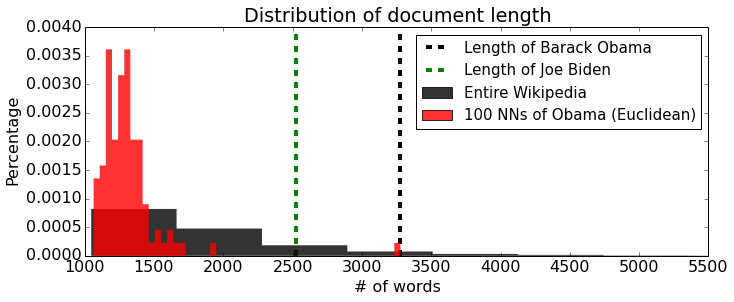

In [76]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'][0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'][0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([1000, 5500, 0, 0.004])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Note: Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to cosine distances:

d(\mathbf{x},\mathbf{y}) = 1 - \dfrac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|\|\mathbf{y}\|}

Cosine distances let us compare word distributions of two articles of varying lengths.

Let us train a new nearest neighbor model, this time with cosine distances. We then repeat the search for Obama's 100 nearest neighbors.

In [77]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(tf_idf)
distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = sframe.SFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_cosine = wiki.join(neighbors, on='id')[['id', 'name', 'length', 'distance']].sort('distance')
print nearest_neighbors_cosine

+-------+-------------------------+--------+--------------------+
|   id  |           name          | length |      distance      |
+-------+-------------------------+--------+--------------------+
| 35817 |       Barack Obama      |  3278  | -1.11022302463e-15 |
| 24478 |        Joe Biden        |  2523  |   0.703138676734   |
| 38376 |      Samantha Power     |  1911  |   0.742981902328   |
| 57108 |  Hillary Rodham Clinton |  3472  |   0.758358397887   |
| 38714 | Eric Stern (politician) |  1589  |   0.770561227601   |
| 46140 |       Robert Gibbs      |  1572  |   0.784677504751   |
|  6796 |       Eric Holder       |  1430  |   0.788039072943   |
| 44681 |  Jesse Lee (politician) |  1374  |   0.790926415366   |
| 18827 |       Henry Waxman      |  1607  |   0.798322602893   |
|  2412 |     Joe the Plumber     |  1422  |   0.799466360042   |
+-------+-------------------------+--------+--------------------+
[100 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can

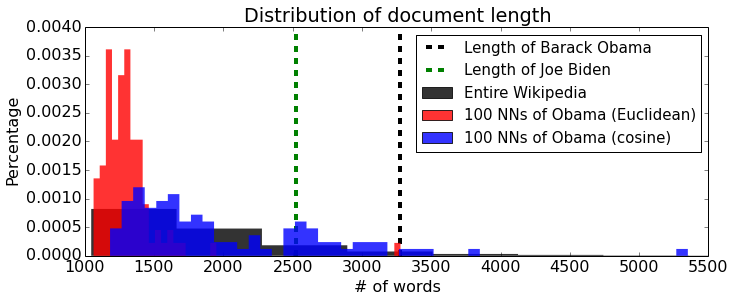

In [78]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'][0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'][0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([1000, 5500, 0, 0.004])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

## Moral of the story: In deciding the features and distance measures, check if they produce results that make sense for your particular application.